In [1]:
# Cell 1: imports & basic config

import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Cell 2: paths & hyperparameters

img_folder    = "./dataset/G2RPL_pt_100_800_2_5_1_3_20_40_05_3_100000/img"      # form factor 
target_folder = "./dataset/G2RPL_pt_100_800_2_5_1_3_20_40_05_3_100000/target"   # bunch profile 

sequence_length = 256       
batch_size = 256
num_epochs = 200
learning_rate = 1e-3
val_ratio = 0.2              


In [3]:
# Cell 3: collect and match file lists

img_files = sorted([f for f in os.listdir(img_folder) if f.endswith(".pt")])
tgt_files = sorted([f for f in os.listdir(target_folder) if f.endswith(".pt")])

print("Number of img files   :", len(img_files))
print("Number of target files:", len(tgt_files))

assert len(img_files) == len(tgt_files), "img 和 target 文件数量不一致！"


for i in range(min(3, len(img_files))):
    print(f"Pair {i}: img={img_files[i]}  <->  target={tgt_files[i]}")


Number of img files   : 100000
Number of target files: 100000
Pair 0: img=G2RP_pt_100000_Q1_660.30103_s1_3.8892_Q2_299.07173_s2_2.5712_r_2.20784_d_21.49431_FF.pt  <->  target=G2RP_pt_100000_Q1_660.30103_s1_3.8892_Q2_299.07173_s2_2.5712_r_2.20784_d_21.49431.pt
Pair 1: img=G2RP_pt_10000_Q1_131.77582_s1_4.81277_Q2_58.83833_s2_1.13692_r_2.23963_d_24.95344_FF.pt  <->  target=G2RP_pt_10000_Q1_131.77582_s1_4.81277_Q2_58.83833_s2_1.13692_r_2.23963_d_24.95344.pt
Pair 2: img=G2RP_pt_10001_Q1_332.21103_s1_2.52689_Q2_201.57137_s2_1.6017_r_1.64811_d_24.46772_FF.pt  <->  target=G2RP_pt_10001_Q1_332.21103_s1_2.52689_Q2_201.57137_s2_1.6017_r_1.64811_d_24.46772.pt


In [4]:
# Cell 4: custom Dataset

class CTRDataset(Dataset):
    def __init__(self, img_folder, tgt_folder, img_files, tgt_files, seq_len=256):
        self.img_folder = img_folder
        self.tgt_folder = tgt_folder
        self.img_files = img_files
        self.tgt_files = tgt_files
        self.seq_len = seq_len

        self.cache_img = {}
        self.cache_tgt = {}

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.img_files[idx])
        tgt_path = os.path.join(self.tgt_folder, self.tgt_files[idx])

        # read form factor
        # df_img = pd.read_csv(img_path)
        # read "F2"
        # F2 = df_img.iloc[:, 1].values if "F2" not in df_img.columns else df_img["F2"].values
        
        # -------- read FF (pt) --------
        # img_sample = torch.load(img_path)
        if img_path not in self.cache_img:
            self.cache_img[img_path] = torch.load(img_path)
        
        img_sample = self.cache_img[img_path]
        F2 = img_sample["F2"]                        # tensor shape (L,)
        F2 = F2.float()

        # read bunch profile
        # df_tgt = pd.read_csv(tgt_path)
        # read "Intensity"
        # y = df_tgt.iloc[:, 1].values if "Intensity" not in df_tgt.columns else df_tgt["Intensity"].values

        # -------- read bunch profile (pt) --------
        # tgt_sample = torch.load(tgt_path)
        if tgt_path not in self.cache_tgt:
            self.cache_tgt[tgt_path] = torch.load(tgt_path)

        tgt_sample = self.cache_tgt[tgt_path]
        y = tgt_sample["Intensity"]                  # tensor shape (L,)
        y = y.float()

        # seq_len
        assert len(F2) == self.seq_len, f"Form factor length {len(F2)} != {self.seq_len}"
        assert len(y)  == self.seq_len, f"Bunch length {len(y)} != {self.seq_len}"

        # normalize to 0-1
        F2_norm = F2 / (F2.max() + 1e-8)
        y_norm  = y  / (y.max()  + 1e-8)

        # to tensor
        # img_tensor = torch.tensor(F2_norm, dtype=torch.float32).unsqueeze(0)  # (1, L)
        # tgt_tensor = torch.tensor(y_norm,  dtype=torch.float32).unsqueeze(0)  # (1, L)

        img_tensor = F2_norm.unsqueeze(0)   # shape: (1, L)
        tgt_tensor = y_norm.unsqueeze(0)    # shape: (1, L)

        return img_tensor, tgt_tensor

# 创建完整数据集
full_dataset = CTRDataset(img_folder, target_folder, img_files, tgt_files, seq_len=sequence_length)
print("Total samples in dataset:", len(full_dataset))


Total samples in dataset: 100000


In [5]:
# Cell 5: split into train / val and create DataLoaders

num_total = len(full_dataset)
num_val = int(num_total * val_ratio)
num_train = num_total - num_val

train_dataset, val_dataset = random_split(full_dataset, [num_train, num_val])

print(f"Train samples: {num_train}, Val samples: {num_val}")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=4,          
    # pin_memory=True,        
    # persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    # num_workers=4,
    # pin_memory=True,
    # persistent_workers=True
)

Train samples: 80000, Val samples: 20000


In [6]:
# Cell 6: define 1D Dilated ResNet for CTR inverse

class DilatedResBlock(nn.Module):
    def __init__(self, ch, kernel_size=5, dilation=1):
        super().__init__()
        pad = (kernel_size // 2) * dilation

        self.conv = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size,
                      padding=pad, dilation=dilation),
            nn.ReLU(inplace=True),
            nn.Conv1d(ch, ch, kernel_size,
                      padding=pad, dilation=dilation),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(x + self.conv(x))  # residual


class Dilated_ResNet(nn.Module):
    def __init__(self, in_ch=1, base_ch=64):
        super().__init__()

        # first layer
        self.in_conv = nn.Conv1d(in_ch, base_ch, kernel_size=3, padding=1)

        # 6 dilated residual blocks
        self.block1 = DilatedResBlock(base_ch, dilation=1)
        self.block2 = DilatedResBlock(base_ch, dilation=2)
        self.block3 = DilatedResBlock(base_ch, dilation=4)
        self.block4 = DilatedResBlock(base_ch, dilation=8)
        self.block5 = DilatedResBlock(base_ch, dilation=16)
        self.block6 = DilatedResBlock(base_ch, dilation=32)

        # output
        self.out_conv = nn.Conv1d(base_ch, 1, kernel_size=1)

    def forward(self, x):
        x = self.in_conv(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.out_conv(x)
        return x


model = Dilated_ResNet(in_ch=1, base_ch=64).to(device)

print(model)


Dilated_ResNet(
  (in_conv): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (block1): DilatedResBlock(
    (conv): Sequential(
      (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): ReLU(inplace=True)
      (2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    )
    (relu): ReLU(inplace=True)
  )
  (block2): DilatedResBlock(
    (conv): Sequential(
      (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,))
      (1): ReLU(inplace=True)
      (2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,))
    )
    (relu): ReLU(inplace=True)
  )
  (block3): DilatedResBlock(
    (conv): Sequential(
      (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(4,))
      (1): ReLU(inplace=True)
      (2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(4,))
    )
    (relu): ReLU(inplace=True)
  )
  (block4): DilatedResBlock(
    (conv): Sequential(
 

In [7]:
# Cell 7: training & validation loops

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for img, tgt in loader:
        img = img.to(device)   # (B,1,L)
        tgt = tgt.to(device)   # (B,1,L)

        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, tgt)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for img, tgt in loader:
            img = img.to(device)
            tgt = tgt.to(device)
            pred = model(img)
            loss = criterion(pred, tgt)
            running_loss += loss.item() * img.size(0)
    return running_loss / len(loader.dataset)


In [8]:
# Cell 8: run training with TensorBoard logging

# create TensorBoard logs
writer = SummaryWriter(log_dir="./logs/exp11")

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss   = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # TensorBoard
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val",   val_loss, epoch)

    print(f"Epoch [{epoch:03d}/{num_epochs}] "
          f"Train Loss: {train_loss:.6f}  |  Val Loss: {val_loss:.6f}")
    
    torch.save(model, "./model/exp11/Dilated_ResNet_{}.pth".format(epoch))

writer.close()
print("Training finished. Logs saved to ./logs/exp11")


Epoch [001/200] Train Loss: 0.011761  |  Val Loss: 0.002072
Epoch [002/200] Train Loss: 0.001764  |  Val Loss: 0.001518
Epoch [003/200] Train Loss: 0.001378  |  Val Loss: 0.001352
Epoch [004/200] Train Loss: 0.001128  |  Val Loss: 0.000958
Epoch [005/200] Train Loss: 0.001009  |  Val Loss: 0.000924
Epoch [006/200] Train Loss: 0.000847  |  Val Loss: 0.001029
Epoch [007/200] Train Loss: 0.000793  |  Val Loss: 0.000869
Epoch [008/200] Train Loss: 0.000725  |  Val Loss: 0.000675
Epoch [009/200] Train Loss: 0.000682  |  Val Loss: 0.000656
Epoch [010/200] Train Loss: 0.000662  |  Val Loss: 0.000641
Epoch [011/200] Train Loss: 0.000647  |  Val Loss: 0.000685
Epoch [012/200] Train Loss: 0.000630  |  Val Loss: 0.000649
Epoch [013/200] Train Loss: 0.000610  |  Val Loss: 0.000633
Epoch [014/200] Train Loss: 0.000590  |  Val Loss: 0.000608
Epoch [015/200] Train Loss: 0.000589  |  Val Loss: 0.000563
Epoch [016/200] Train Loss: 0.000579  |  Val Loss: 0.000565
Epoch [017/200] Train Loss: 0.000574  | 

Loading model: ./model/exp11/Dilated_ResNet_140.pth


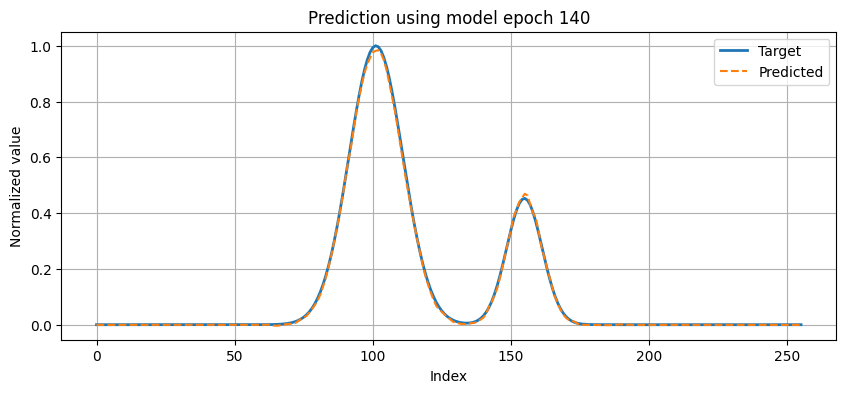

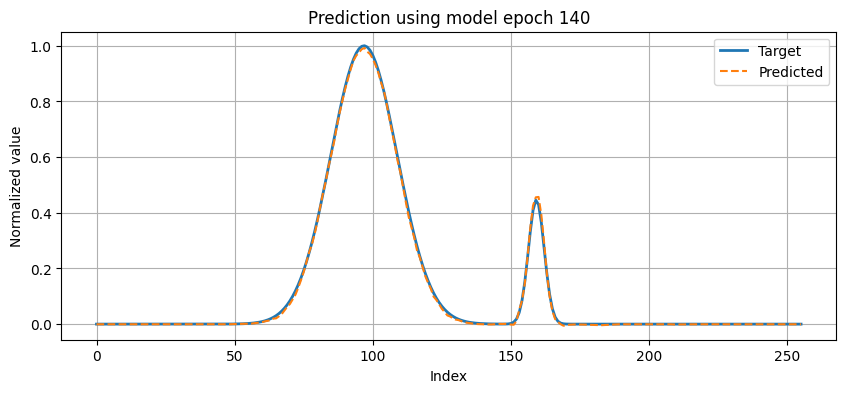

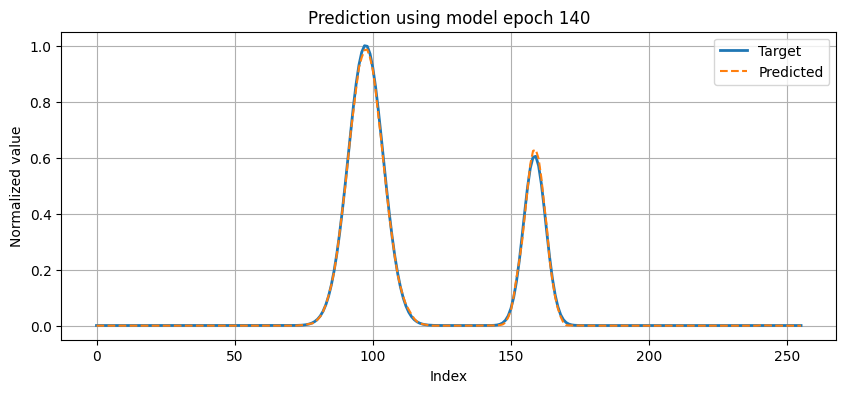

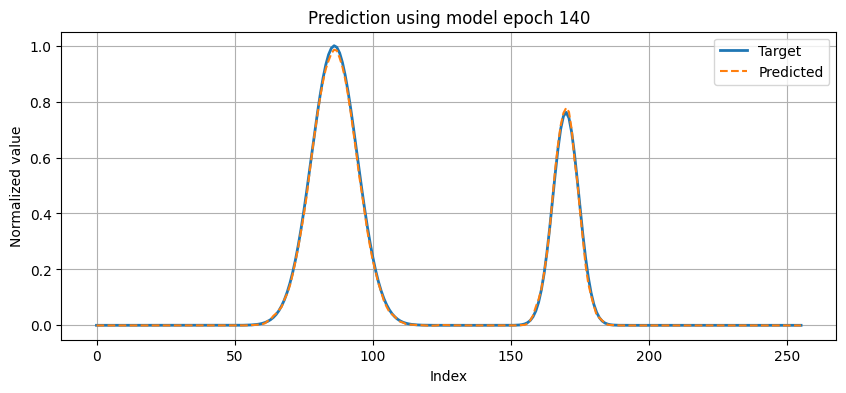

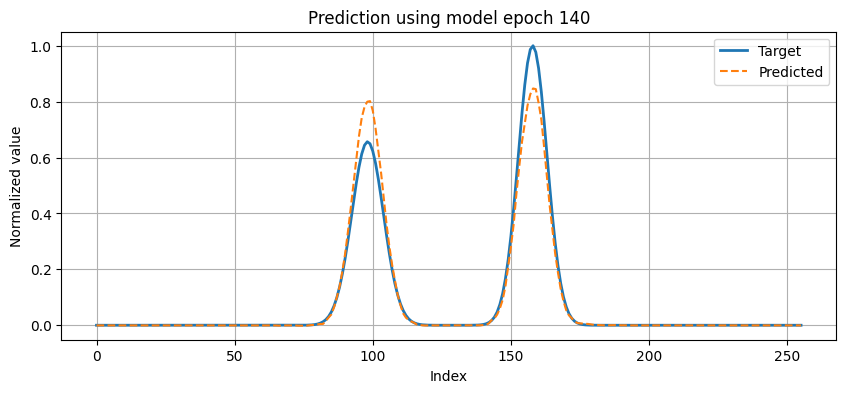

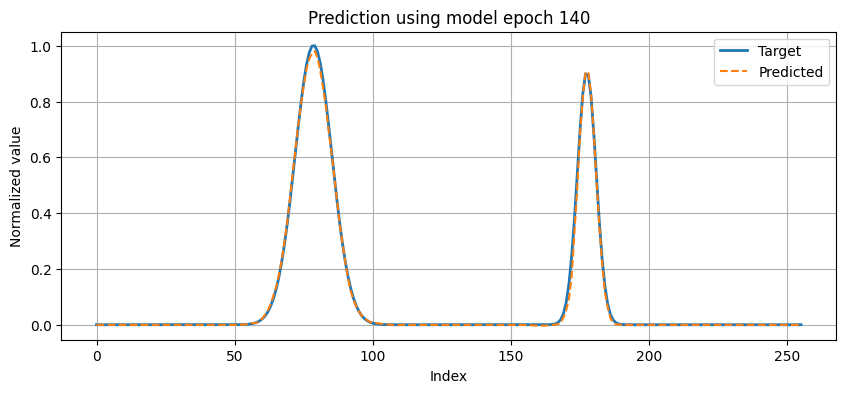

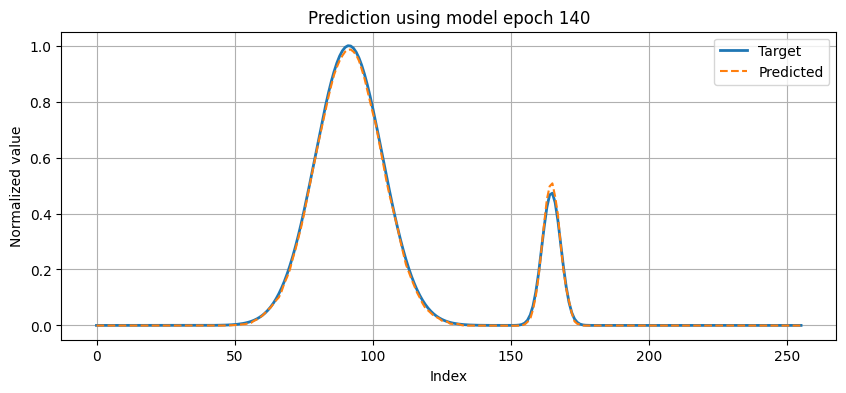

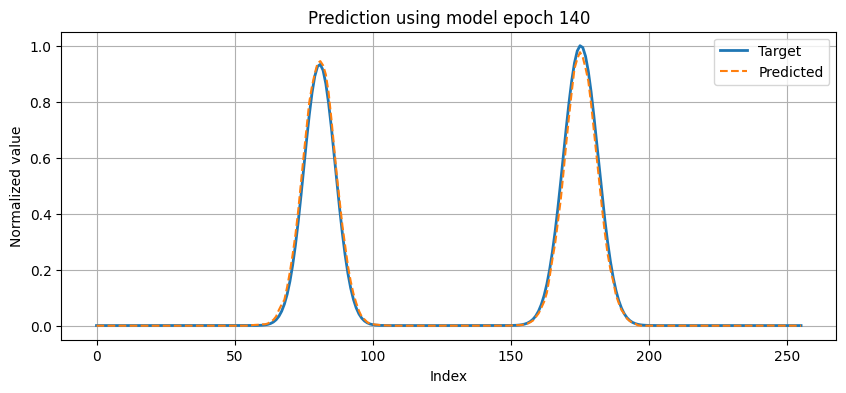

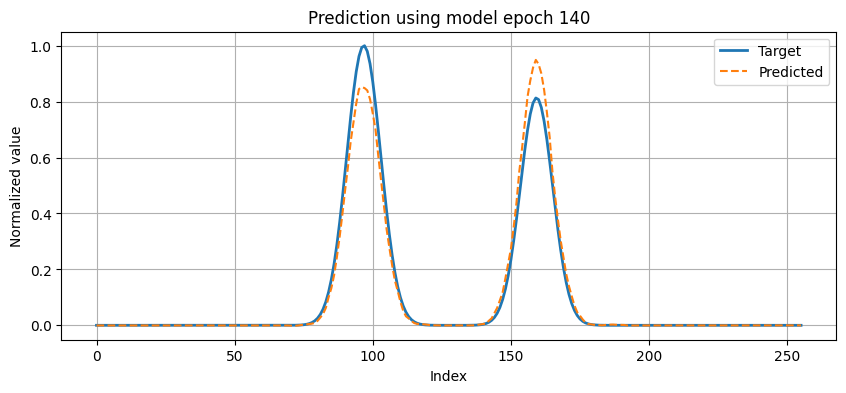

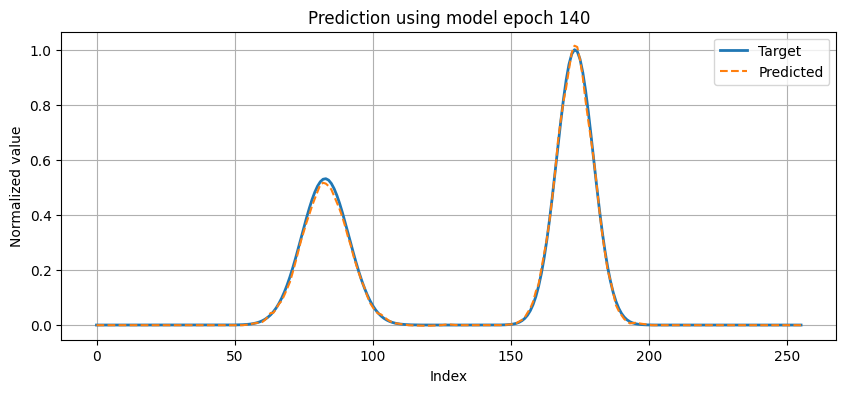

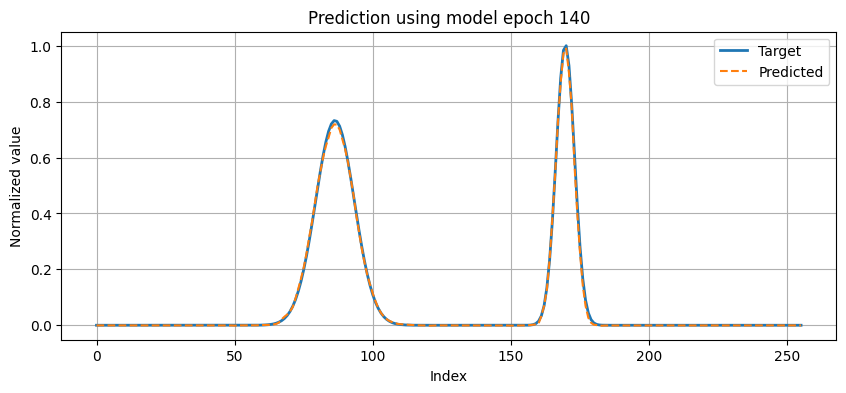

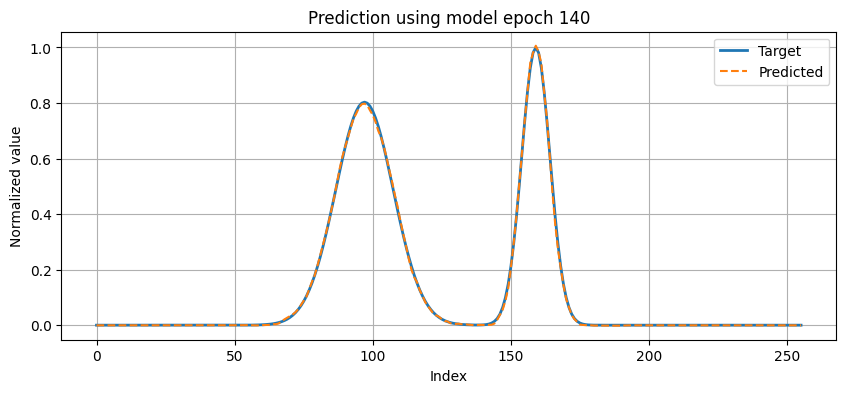

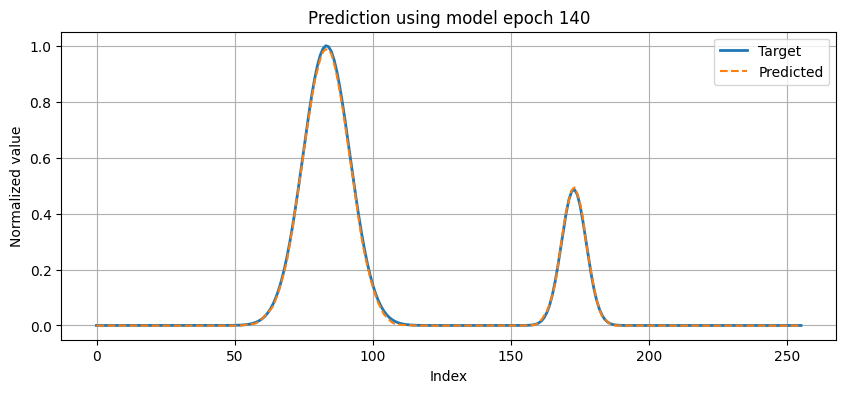

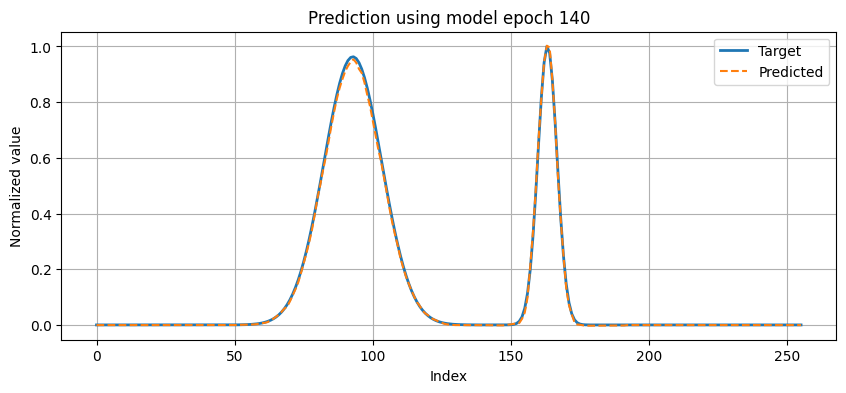

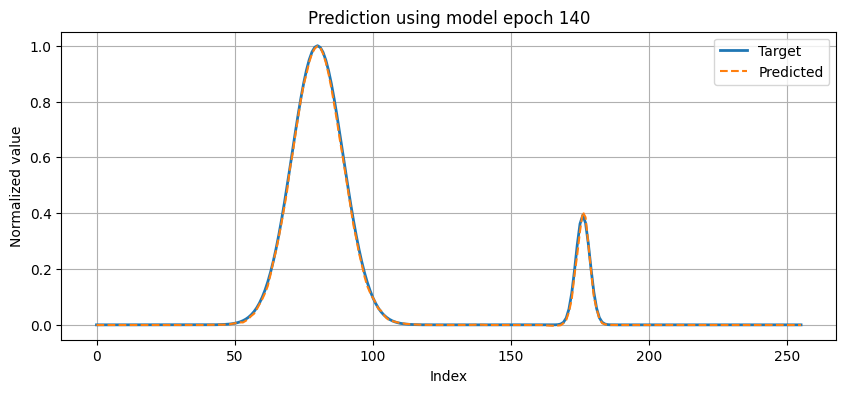

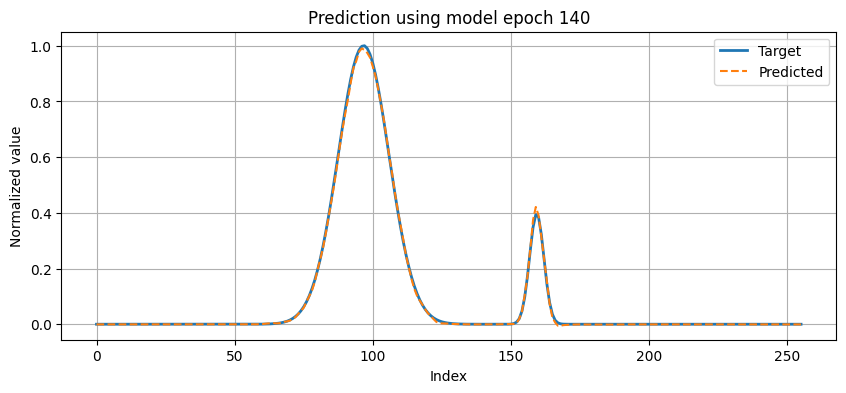

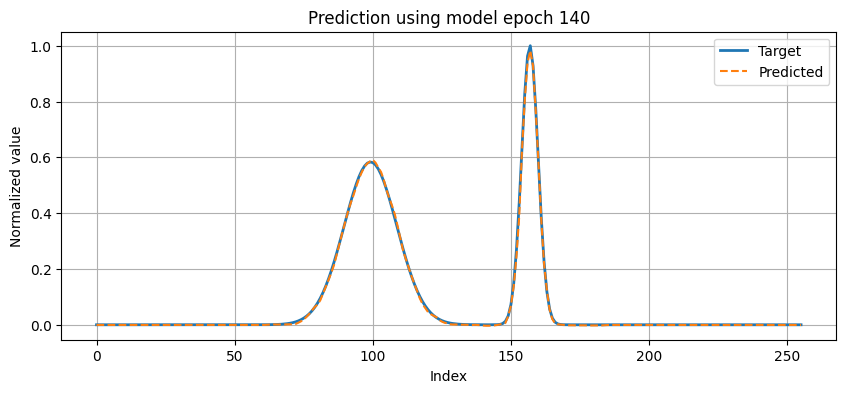

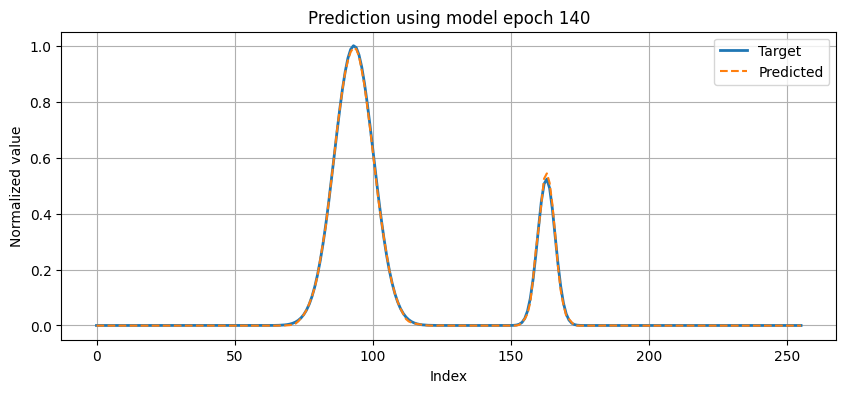

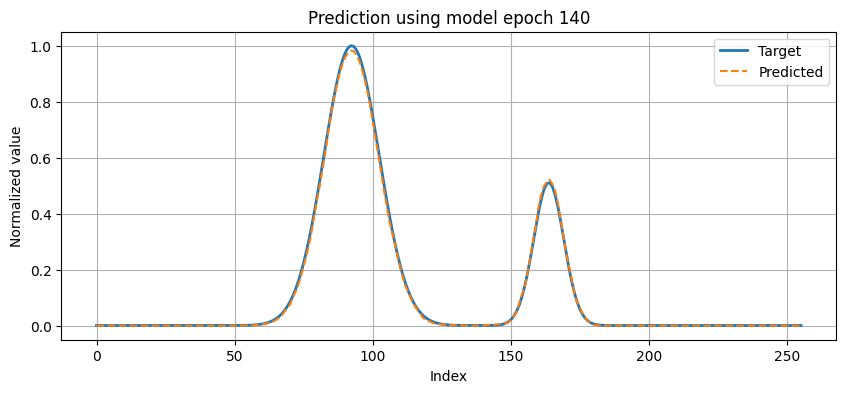

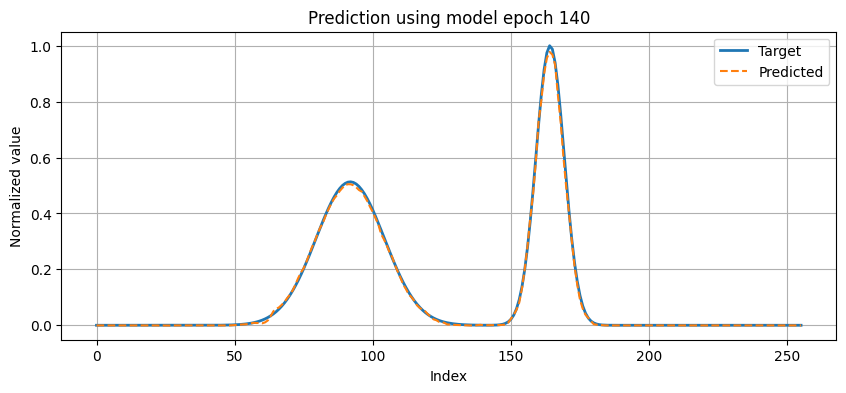

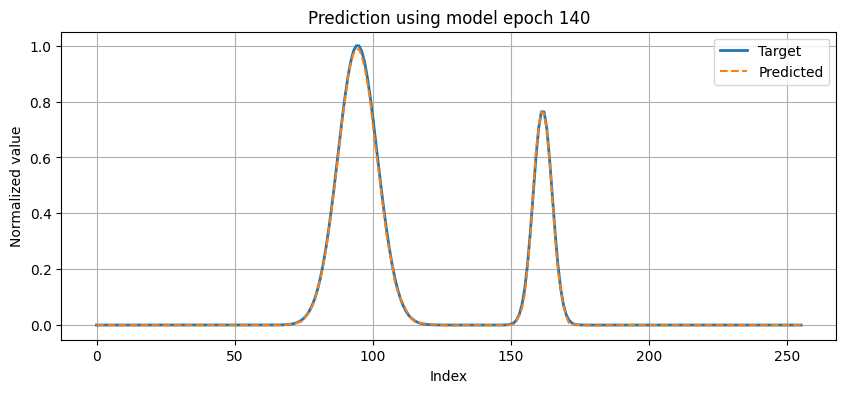

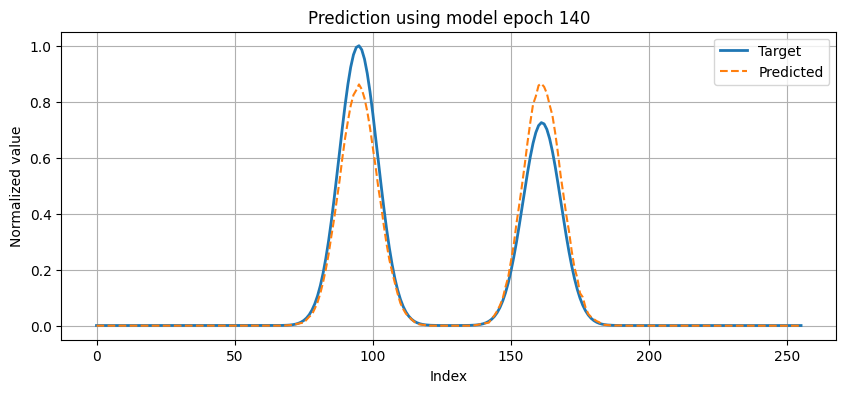

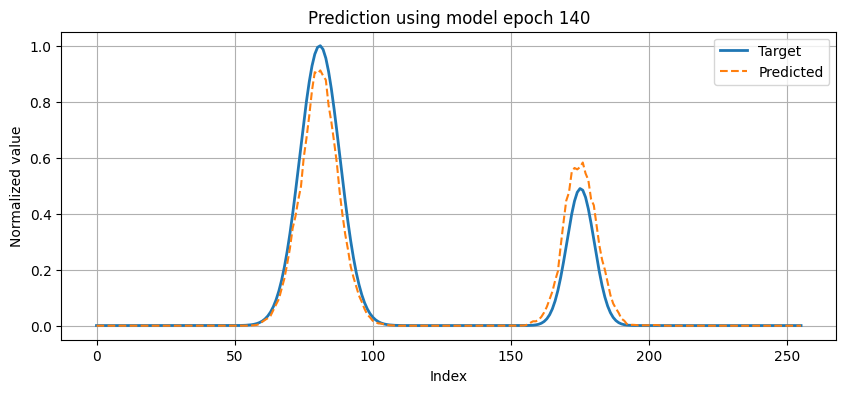

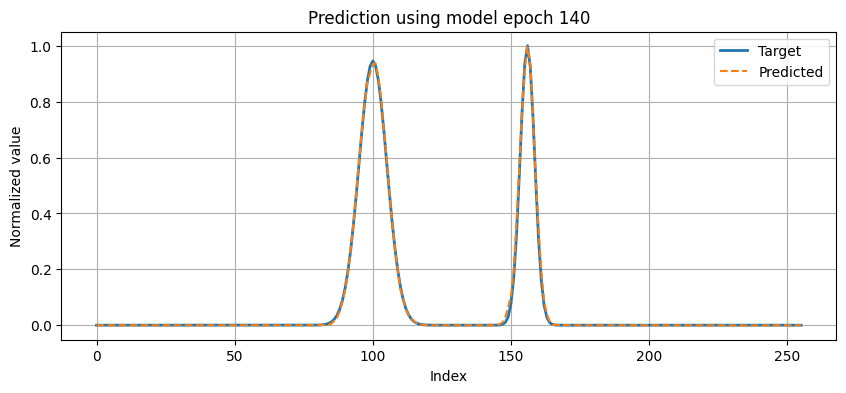

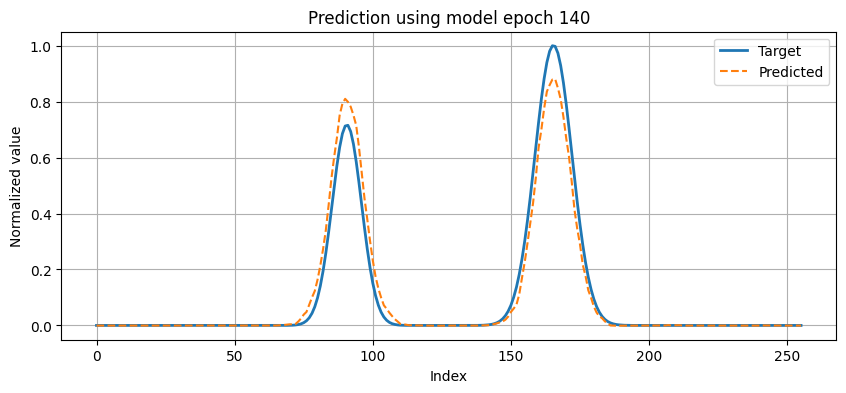

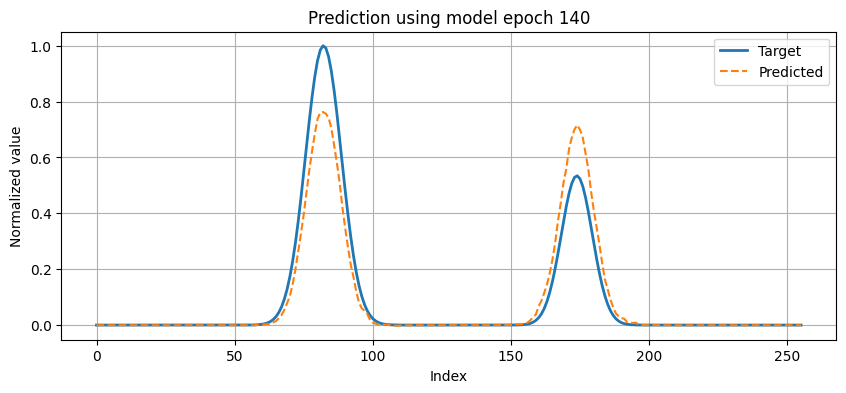

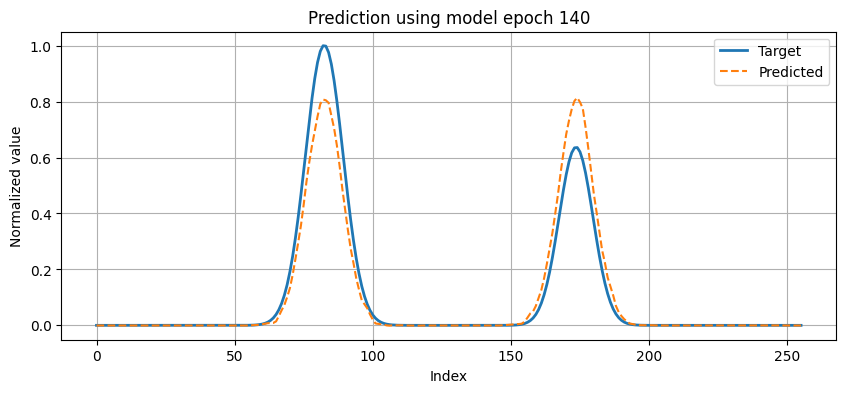

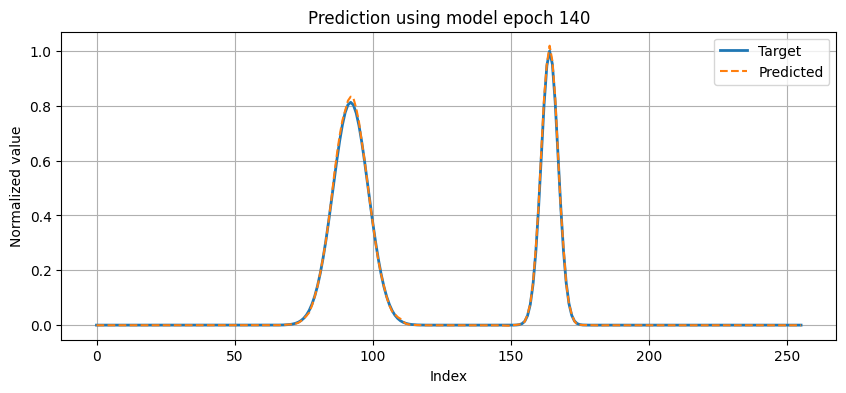

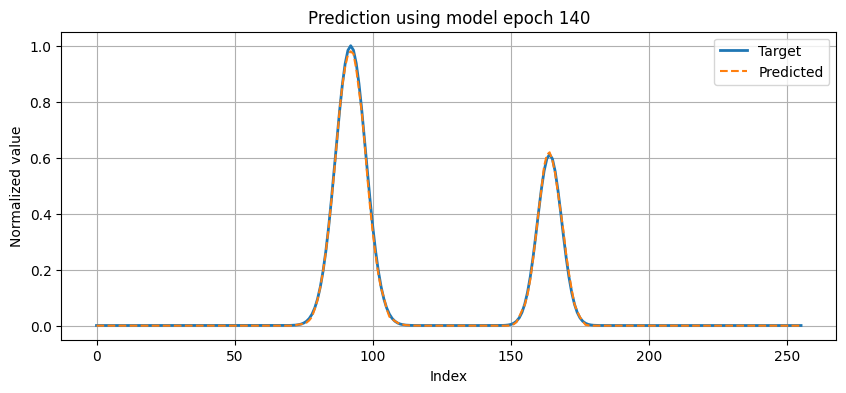

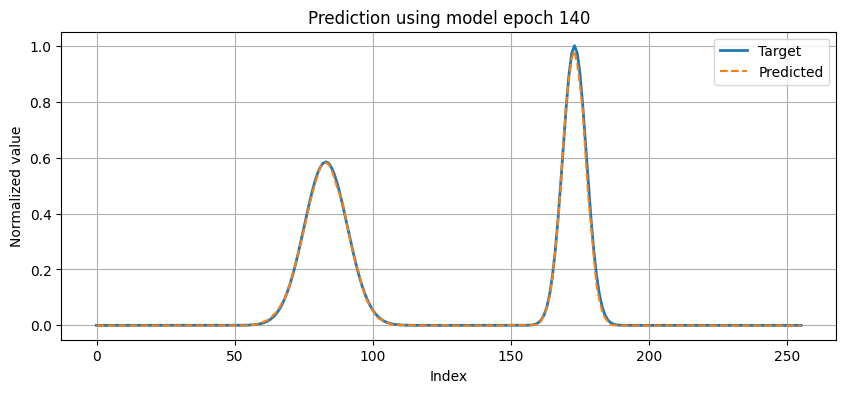

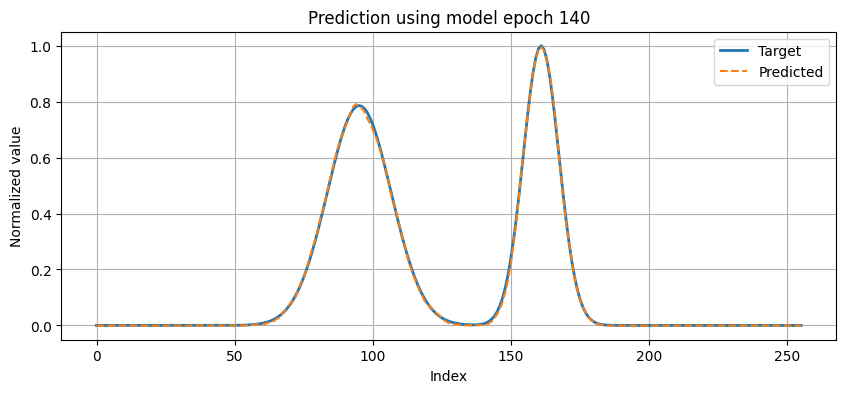

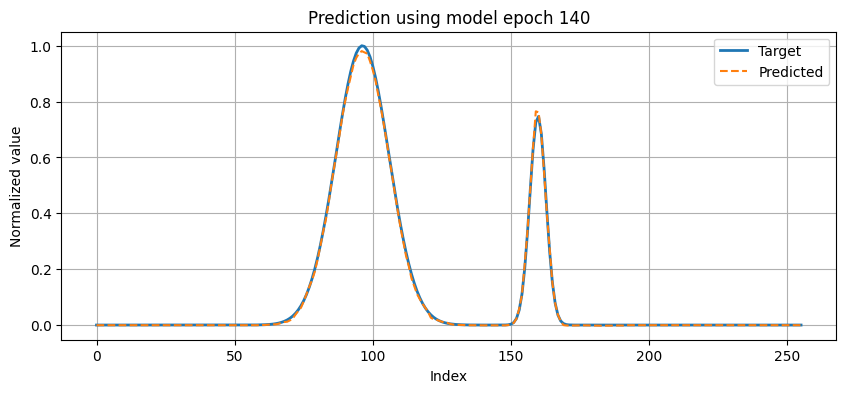

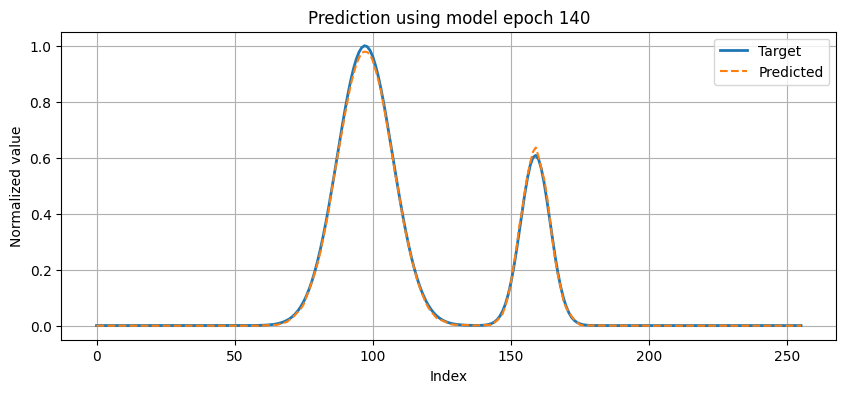

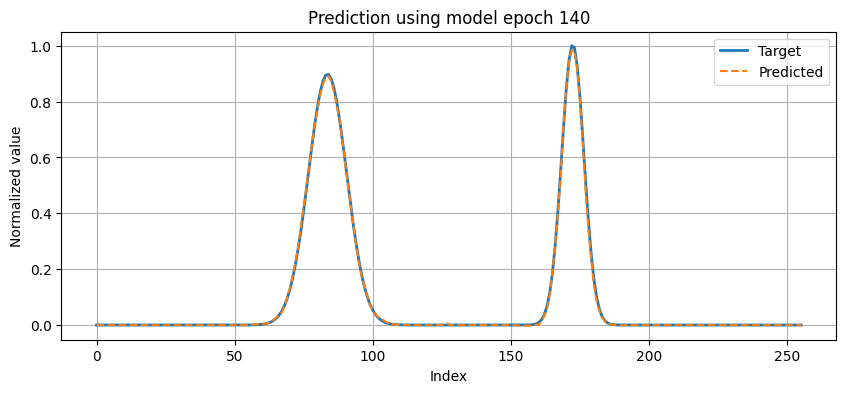

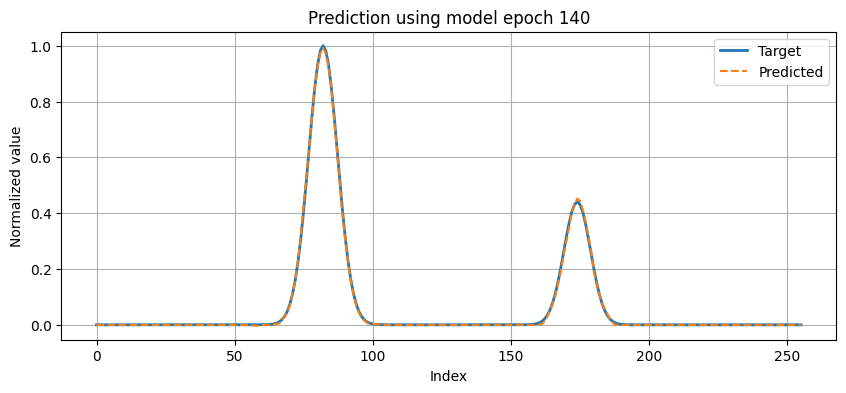

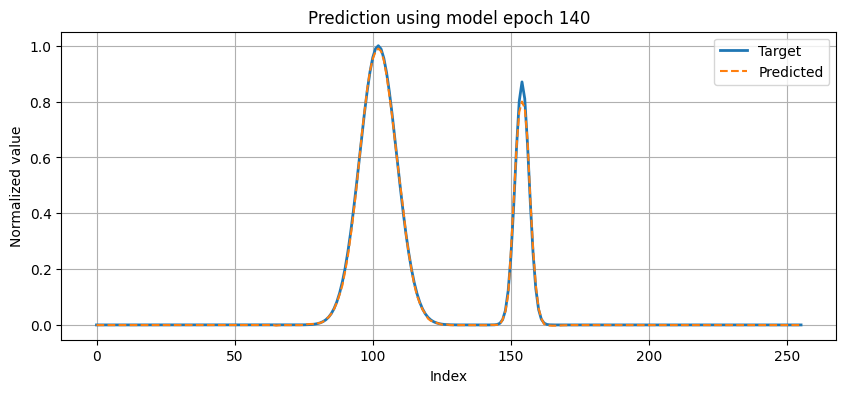

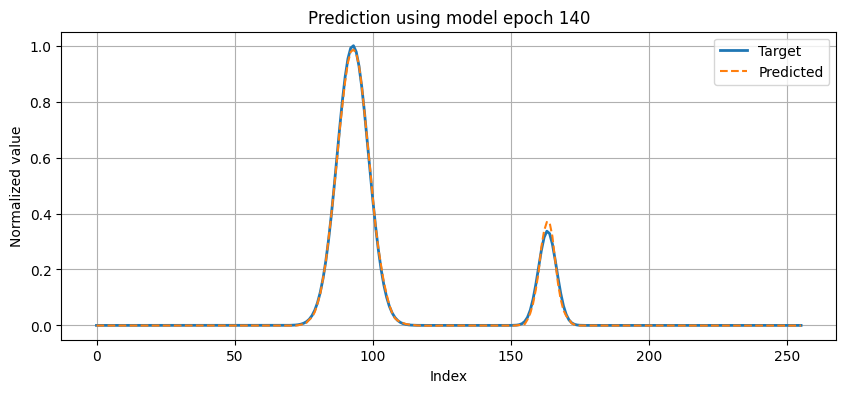

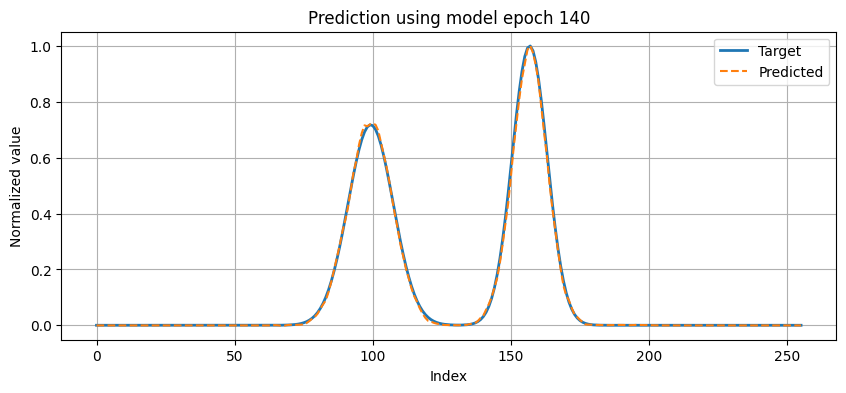

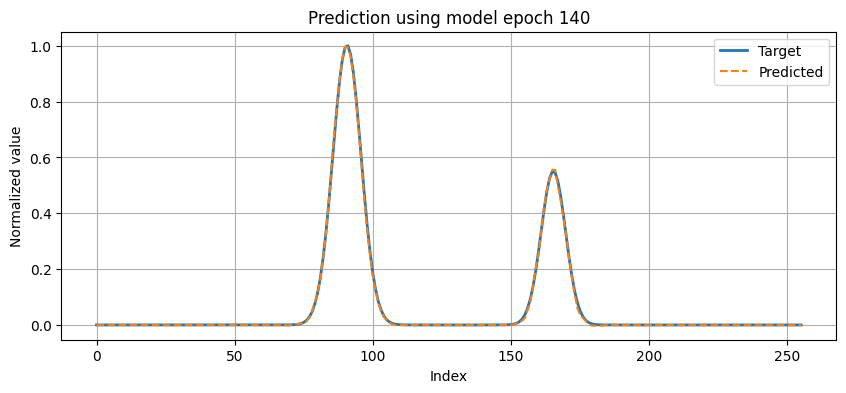

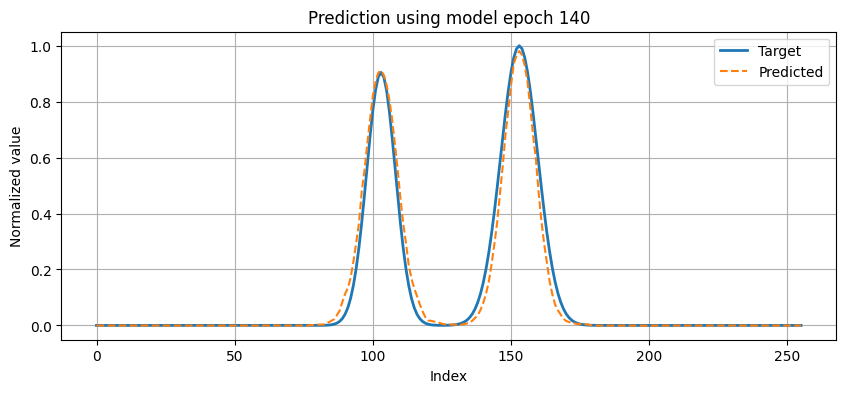

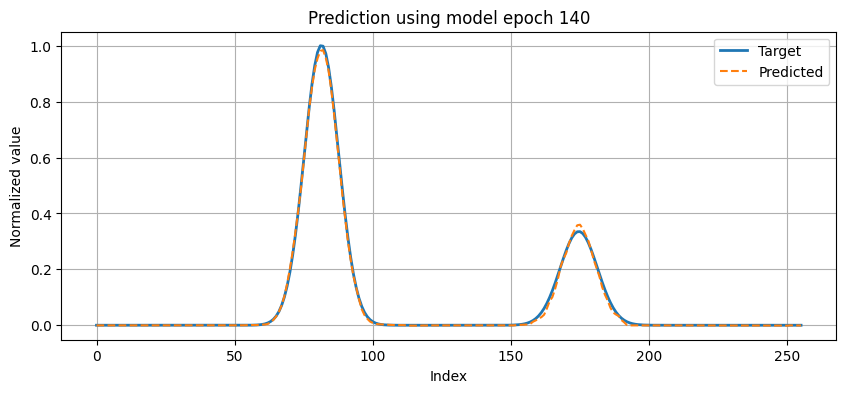

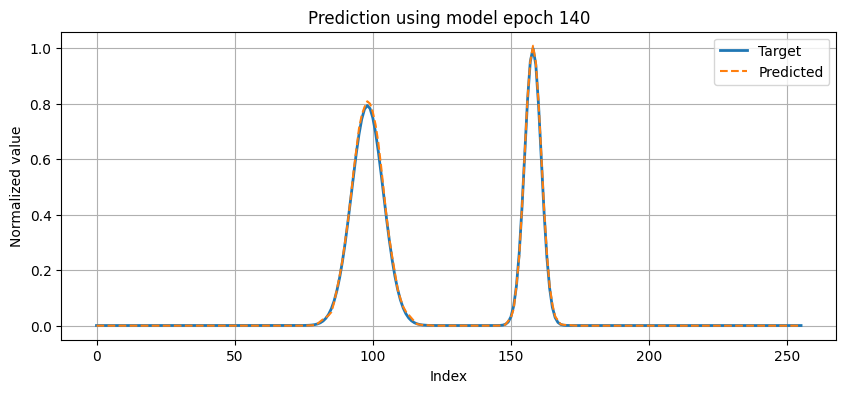

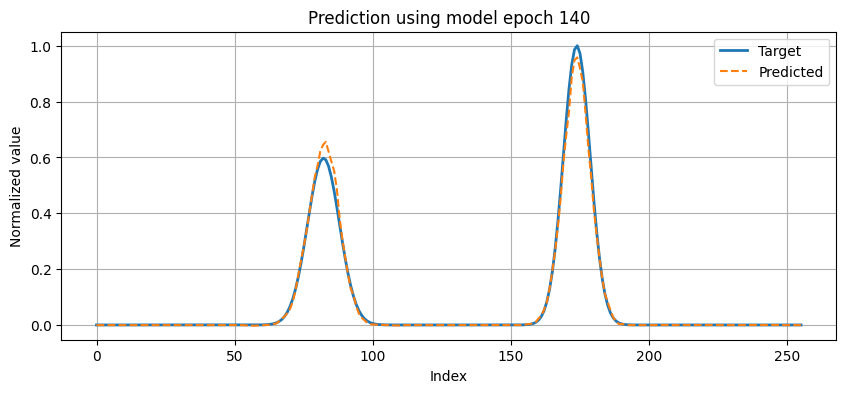

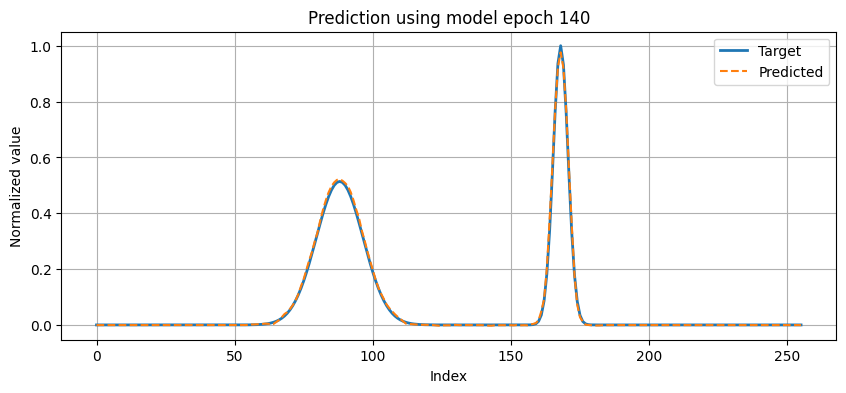

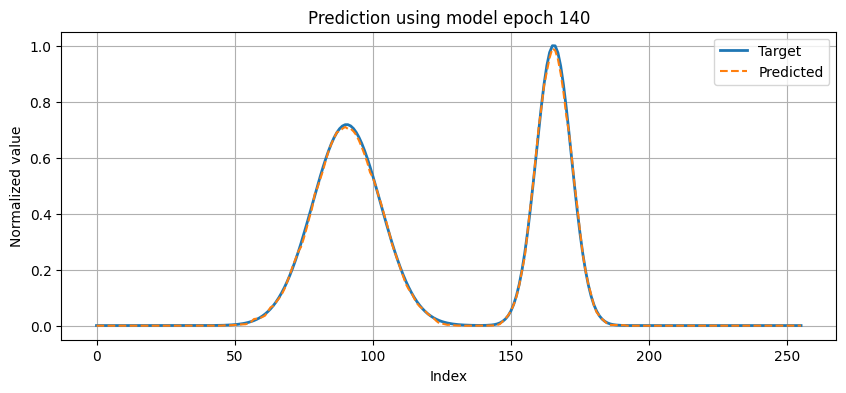

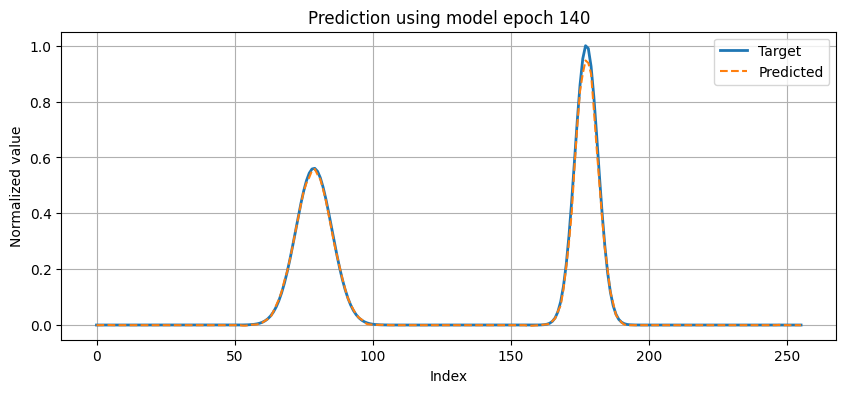

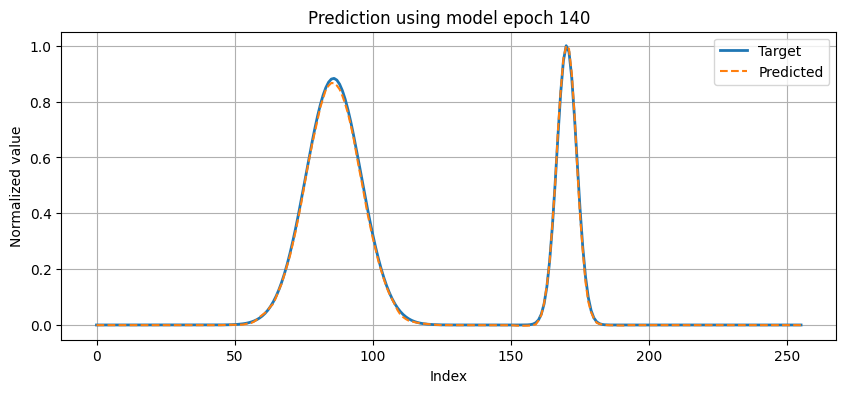

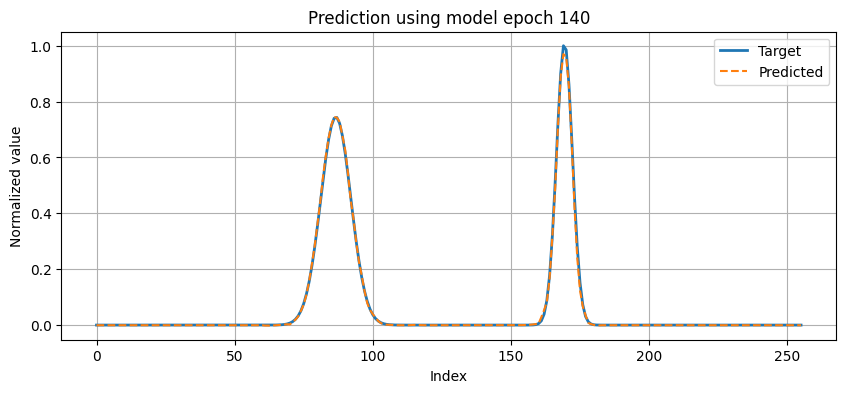

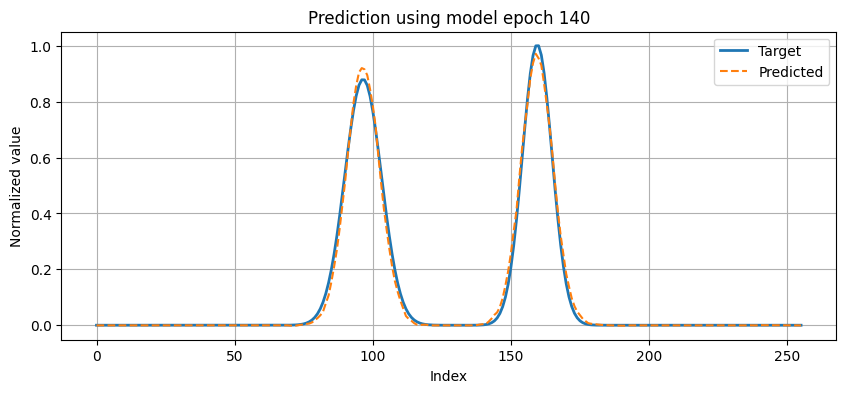

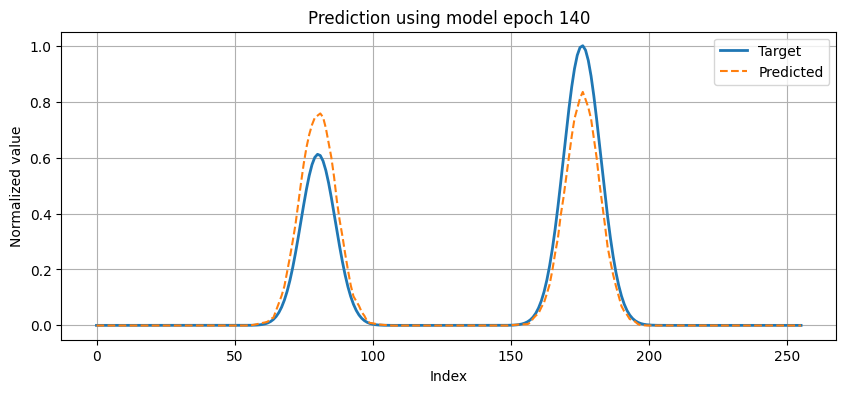

In [9]:
# Cell 9: load epoch-140 model and test prediction

import matplotlib.pyplot as plt
from torch.serialization import add_safe_globals
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

add_safe_globals([Dilated_ResNet])

model_path = "./model/exp11/Dilated_ResNet_140.pth"
print("Loading model:", model_path)

model_140 = torch.load(model_path, map_location=device, weights_only=False)
model_140.eval()

for idx in range(50):
    img, tgt = full_dataset[idx]

    img = img.unsqueeze(0).to(device)     # (1,1,1024)
    tgt = tgt.squeeze().cpu().numpy()     # (1024,)

    with torch.no_grad():
        pred = model_140(img).squeeze().cpu().numpy()   # (1024,)

    # （5）画图：target vs pred
    plt.figure(figsize=(10,4))
    plt.plot(tgt, label="Target", linewidth=2)
    plt.plot(pred, label="Predicted", linestyle='--')
    plt.xlabel("Index")
    plt.ylabel("Normalized value")
    plt.title("Prediction using model epoch 140")
    plt.grid(True)
    plt.legend()
    plt.show()

